In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import pandas as pd
import matplotlib.pyplot as plt

import gc
import time
from datetime import timedelta

from ResNet import get_model
from utils import count_trainable_parameters, count_total_parameters
from utils import clear_gpu_memory, get_gpu_memory
from utils import plot_metrics, create_summary_table
from utils import get_device, get_dataloaders
from utils import train_one_epoch, evaluate

In [2]:
def load_dataset_metrics(dataset):
    metrics = {
        'train_acc': {},
        'test_acc': {},
        'train_loss': {},
        'test_loss': {},
    }
    for arch in architectures:
        for mode in modes:
            filename = f"{dataset}_{arch}_{mode}_metrics.csv"
            path = os.path.join(results_dir, filename)
            if os.path.exists(path):
                df = pd.read_csv(path)
                label = f"{arch}_{mode}"
                metrics['train_acc'][label] = df['train_acc']
                metrics['test_acc'][label] = df['test_acc']
                metrics['train_loss'][label] = df['train_loss']
                metrics['test_loss'][label] = df['test_loss']
    return metrics

In [3]:
device = get_device()
print(f'device - {device}')

architectures = ['resnet18', 'resnet50']
                 # , 'resnet101']
modes = ['scratch'] 
         # 'transfer']  

batch_size = 128
results_dir = 'resnet_results'
os.makedirs(results_dir, exist_ok=True)

clear_gpu_memory()
get_gpu_memory()



device - cuda
GPU memory allocated: 0.00 GB
GPU memory reserved: 0.00 GB


In [4]:
epochs = 20
dataset_name = "mnist"
trainloader, testloader, num_classes = get_dataloaders(dataset_name, batch_size)
for arch in architectures:
    for mode in modes:
        use_pretrained = (mode == 'transfer')

        print(f"{mode.title()} learning: {arch} on {dataset_name}...")
        total_train_time = 0
        total_eval_time = 0
        start_time = time.time()

            
        model = get_model(arch, num_classes, device, pretrained=use_pretrained)
        criterion = nn.CrossEntropyLoss()
            
        # only fine-tune parameters that require gradients
        optimizer = optim.SGD(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=0.01 if not use_pretrained else 0.001,
            momentum=0.9,
            weight_decay=5e-4
        )


        trainable = count_trainable_parameters(model)
        total = count_total_parameters(model)
        print(f"Trainable parameters: {trainable:,}")
        print(f"Total parameters: {total:,}")
        print(f"Percentage trainable: {trainable/total:.2%}")

        history = []
        for epoch in range(1, epochs + 1):
            epoch_start = time.time()
            
            train_start = time.time()
            train_loss, train_acc = train_one_epoch(model, trainloader, criterion, optimizer, device)
            train_time = time.time() - train_start
            
            eval_start = time.time()
            test_loss, test_acc = evaluate(model, testloader, criterion, device)
            eval_time = time.time() - eval_start
            
            total_train_time += train_time
            total_eval_time += eval_time
            epoch_time = time.time() - epoch_start
            
            print(f"Epoch {epoch}/{epochs} - "
                  f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, "
                  f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")
            print(f"Epoch time: {timedelta(seconds=epoch_time)} "
                  f"(Train: {timedelta(seconds=train_time)}, "
                  f"Eval: {timedelta(seconds=eval_time)}")
                
            history.append({
                'epoch': epoch,
                'train_loss': train_loss,
                'train_acc': train_acc,
                'test_loss': test_loss,
                'test_acc': test_acc,
                'train_time': train_time,
                'eval_time': eval_time,
                'epoch_time': epoch_time
            })

        total_time = time.time() - start_time
        avg_epoch_time = total_time / epochs
        avg_train_time = total_train_time / epochs
        avg_eval_time = total_eval_time / epochs
        
        print("\nTraining Summary:")
        print(f"Total training time: {timedelta(seconds=total_time)}")
        print(f"Average epoch time: {timedelta(seconds=avg_epoch_time)}")
        print(f"Average training time per epoch: {timedelta(seconds=avg_train_time)}")
        print(f"Average evaluation time per epoch: {timedelta(seconds=avg_eval_time)}")
        print(f"Total training time (excluding eval): {timedelta(seconds=total_train_time)}")
        print(f"Total evaluation time: {timedelta(seconds=total_eval_time)}")
        
        csv_name = f"{dataset_name}_{arch}_{mode}_metrics.csv"
        df = pd.DataFrame(history)
        df.to_csv(os.path.join(results_dir, csv_name), index=False)
        print(f"Saved metrics to {results_dir}/{csv_name}\n")

        model_filename = f"{dataset_name}_{arch}_{mode}_model.pth"
        model_path = os.path.join(results_dir, model_filename)
        torch.save(model.state_dict(), model_path)
        print(f"Saved model weights to {model_path}\n")

        clear_gpu_memory()
        get_gpu_memory()

Scratch learning: resnet18 on mnist...
Trainable parameters: 11,181,642
Total parameters: 11,181,642
Percentage trainable: 100.00%
Epoch 1/20 - Train loss: 0.1030, Train acc: 0.9696, Test loss: 0.0298, Test acc: 0.9913
Epoch time: 0:00:15.510696 (Train: 0:00:13.845022, Eval: 0:00:01.665670
Epoch 2/20 - Train loss: 0.0262, Train acc: 0.9920, Test loss: 0.0258, Test acc: 0.9922
Epoch time: 0:00:16.908695 (Train: 0:00:15.207159, Eval: 0:00:01.701535
Epoch 3/20 - Train loss: 0.0181, Train acc: 0.9950, Test loss: 0.0196, Test acc: 0.9934
Epoch time: 0:00:16.788898 (Train: 0:00:15.111942, Eval: 0:00:01.676954
Epoch 4/20 - Train loss: 0.0119, Train acc: 0.9966, Test loss: 0.0240, Test acc: 0.9927
Epoch time: 0:00:16.704686 (Train: 0:00:15.018398, Eval: 0:00:01.686286
Epoch 5/20 - Train loss: 0.0091, Train acc: 0.9973, Test loss: 0.0248, Test acc: 0.9928
Epoch time: 0:00:16.803863 (Train: 0:00:15.132836, Eval: 0:00:01.671026
Epoch 6/20 - Train loss: 0.0101, Train acc: 0.9969, Test loss: 0.0222

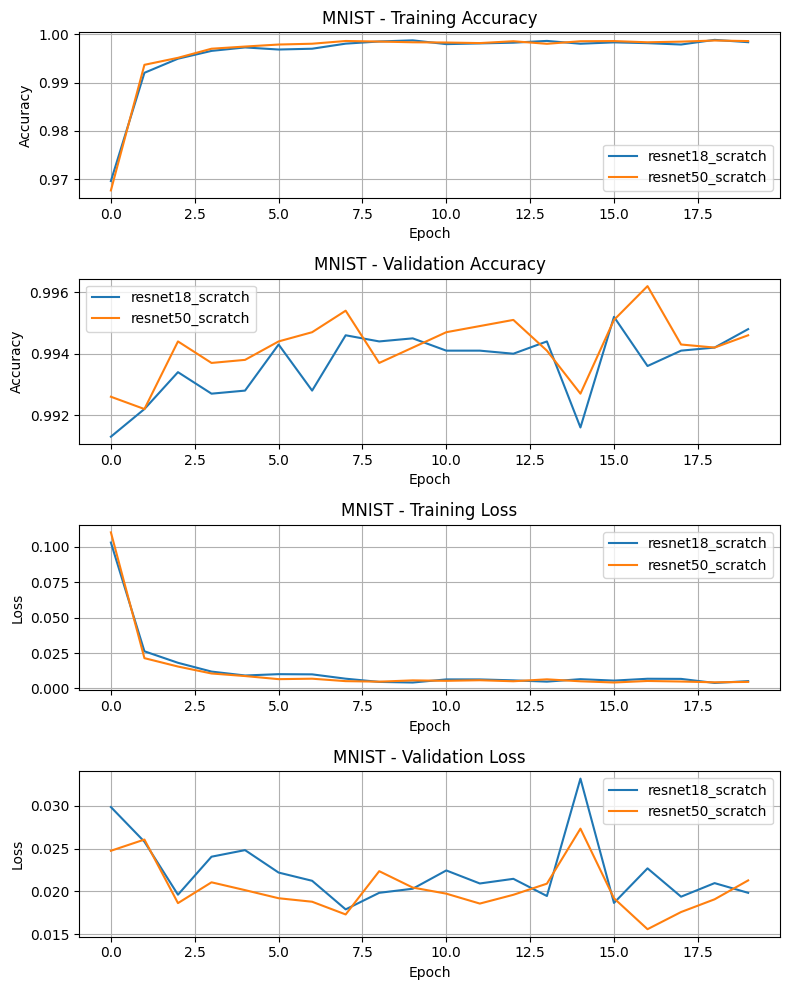

In [5]:

# for dataset in datasets:
epochs=20
dataset_name = "mnist"
metrics = load_dataset_metrics(dataset_name)
plot_metrics(metrics, dataset_name, range(epochs))


In [6]:

# summary_df = create_summary_table()
summary_df = create_summary_table(dataset_name=dataset_name, 
                                  architectures=architectures,
                                 modes=modes,
                                 results_dir=results_dir)
print(summary_df.to_string(index=False))

Dataset    Model    Mode  Final Train Acc  Final Test Acc  Final Test Loss  Best Epoch  Best Test Acc
  MNIST resnet18 scratch           0.9984          0.9948           0.0198          16         0.9952
  MNIST resnet50 scratch           0.9986          0.9946           0.0213          17         0.9962


In [7]:
epochs = 20
dataset_name = "cifar10"
trainloader, testloader, num_classes = get_dataloaders(dataset_name, batch_size)
for arch in architectures:
    for mode in modes:
        use_pretrained = (mode == 'transfer')
        print(f"{mode.title()} learning: {arch} on {dataset_name}...")
        
        total_train_time = 0
        total_eval_time = 0
        start_time = time.time()

            
        model = get_model(arch, num_classes, device, pretrained=use_pretrained)
        criterion = nn.CrossEntropyLoss()
            
        # only fine-tune parameters that require gradients
        optimizer = optim.SGD(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=0.01 if not use_pretrained else 0.001,
            momentum=0.9,
            weight_decay=5e-4
        )


        trainable = count_trainable_parameters(model)
        total = count_total_parameters(model)
        print(f"Trainable parameters: {trainable:,}")
        print(f"Total parameters: {total:,}")
        print(f"Percentage trainable: {trainable/total:.2%}")

        history = []
        for epoch in range(1, epochs + 1):
            epoch_start = time.time()
            
            train_start = time.time()
            train_loss, train_acc = train_one_epoch(model, trainloader, criterion, optimizer, device)
            train_time = time.time() - train_start
            
            eval_start = time.time()
            test_loss, test_acc = evaluate(model, testloader, criterion, device)
            eval_time = time.time() - eval_start
            
            total_train_time += train_time
            total_eval_time += eval_time
            epoch_time = time.time() - epoch_start
            
            print(f"Epoch {epoch}/{epochs} - "
                  f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, "
                  f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")
            print(f"Epoch time: {timedelta(seconds=epoch_time)} "
                  f"(Train: {timedelta(seconds=train_time)}, "
                  f"Eval: {timedelta(seconds=eval_time)}")
                
            history.append({
                'epoch': epoch,
                'train_loss': train_loss,
                'train_acc': train_acc,
                'test_loss': test_loss,
                'test_acc': test_acc,
                'train_time': train_time,
                'eval_time': eval_time,
                'epoch_time': epoch_time
            })

        total_time = time.time() - start_time
        avg_epoch_time = total_time / epochs
        avg_train_time = total_train_time / epochs
        avg_eval_time = total_eval_time / epochs
        
        print("\nTraining Summary:")
        print(f"Total training time: {timedelta(seconds=total_time)}")
        print(f"Average epoch time: {timedelta(seconds=avg_epoch_time)}")
        print(f"Average training time per epoch: {timedelta(seconds=avg_train_time)}")
        print(f"Average evaluation time per epoch: {timedelta(seconds=avg_eval_time)}")
        print(f"Total training time (excluding eval): {timedelta(seconds=total_train_time)}")
        print(f"Total evaluation time: {timedelta(seconds=total_eval_time)}")
            
        csv_name = f"{dataset_name}_{arch}_{mode}_metrics.csv"
        df = pd.DataFrame(history)
        df.to_csv(os.path.join(results_dir, csv_name), index=False)
        print(f"Saved metrics to {results_dir}/{csv_name}\n")

        model_filename = f"{dataset_name}_{arch}_{mode}_model.pth"
        model_path = os.path.join(results_dir, model_filename)
        torch.save(model.state_dict(), model_path)
        print(f"Saved model weights to {model_path}\n")

        clear_gpu_memory()
        get_gpu_memory()


Scratch learning: resnet18 on cifar10...
Trainable parameters: 11,181,642
Total parameters: 11,181,642
Percentage trainable: 100.00%
Epoch 1/20 - Train loss: 0.9044, Train acc: 0.6887, Test loss: 0.6545, Test acc: 0.7729
Epoch time: 0:00:13.547083 (Train: 0:00:12.127657, Eval: 0:00:01.419424
Epoch 2/20 - Train loss: 0.5662, Train acc: 0.8070, Test loss: 0.6403, Test acc: 0.7834
Epoch time: 0:00:13.327385 (Train: 0:00:11.825177, Eval: 0:00:01.502207
Epoch 3/20 - Train loss: 0.4636, Train acc: 0.8422, Test loss: 0.5669, Test acc: 0.8062
Epoch time: 0:00:13.955733 (Train: 0:00:12.423416, Eval: 0:00:01.532315
Epoch 4/20 - Train loss: 0.3970, Train acc: 0.8629, Test loss: 0.5856, Test acc: 0.8036
Epoch time: 0:00:13.642538 (Train: 0:00:12.157934, Eval: 0:00:01.484601
Epoch 5/20 - Train loss: 0.3539, Train acc: 0.8776, Test loss: 0.5155, Test acc: 0.8252
Epoch time: 0:00:13.650436 (Train: 0:00:12.251196, Eval: 0:00:01.399238
Epoch 6/20 - Train loss: 0.3064, Train acc: 0.8953, Test loss: 0.53

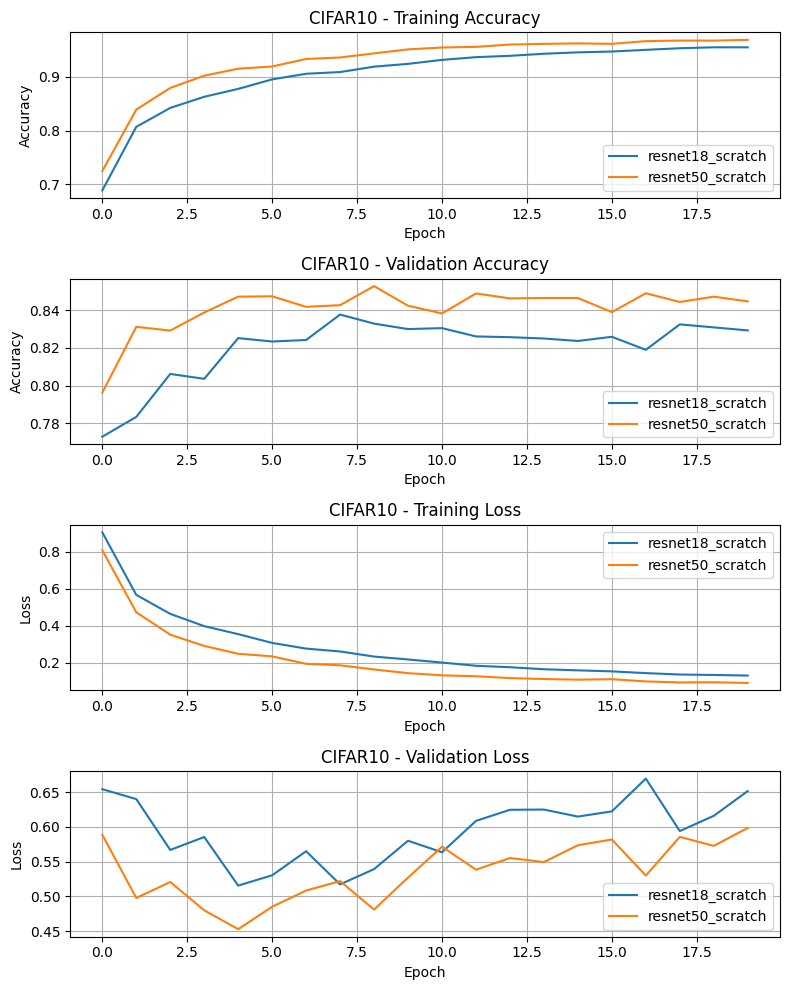

Dataset    Model    Mode  Final Train Acc  Final Test Acc  Final Test Loss  Best Epoch  Best Test Acc
CIFAR10 resnet18 scratch           0.9549          0.8293           0.6518           8         0.8377
CIFAR10 resnet50 scratch           0.9688          0.8447           0.5986           9         0.8528


In [8]:

# Execute for MNIST and CIFAR10
# for dataset in datasets:
dataset_name = "cifar10"
metrics = load_dataset_metrics(dataset_name)
plot_metrics(metrics, dataset_name, range(epochs))

summary_df = create_summary_table(dataset_name=dataset_name, 
                                  architectures=architectures,
                                 modes=modes,
                                 results_dir=results_dir)
print(summary_df.to_string(index=False))